In [1]:
import os

from dotenv import load_dotenv
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import plot_error_map, plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeFez
from qiskit.providers import BackendV2 as Backend

# Práctica HW1: Hardware Cuántico

## Construir el circuito

Construimos el circuito que genera el siguiente estado de Bell:
$$
|\phi \rangle = \frac{1}{\sqrt{2}} (|00 \rangle + |11 \rangle)
$$

In [2]:
qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

bell_state = Statevector(qc)
bell_state.draw("latex")

<IPython.core.display.Latex object>

## Incluir las medidas

Incluimos una medida de los 2 qubits y dibujamos el circuito.

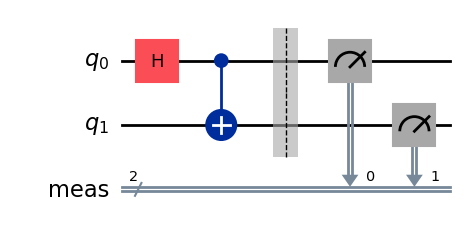

In [3]:
qc.measure_all()
qc.draw(output="mpl")

## Ejecución del circuito

Primero de todo, definimos una función `run_circuit` que, dados un circuito y un backend, realiza la ejecución con un determinado número de shots.

In [4]:
def run_circuit(qc: QuantumCircuit, backend: Backend, nshots: int=1000) -> None:
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(qc)

    sampler = Sampler(backend, options={"default_shots": nshots})

    job = sampler.run([isa_circuit])
    result = job.result()
    pub_result = result[0]

    display(plot_histogram(pub_result.data.meas.get_counts(), figsize=(5, 4.5)))

### Ejecución en un simulador cuántico ideal

Utilizamos el simulador cuántico sin ruido `AerSimulator` para obtener la distribución de probabilidad teórica.

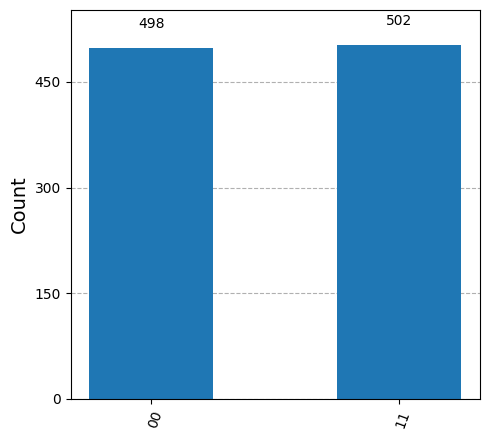

In [5]:
run_circuit(qc, AerSimulator())

### Ejecución en un computador cuántico real de IBM

Primero de todo, cargamos la clave, la cual está almacenada en un fichero `.env` en la raíz del proyecto.

De esta manera evitamos exponer nuestra clave privada al compartir el notebook:

In [6]:
load_dotenv()
ibm_key = os.getenv("IBM_KEY")

Una vez ya tenemos nuestra clave, guardamos la cuenta:

In [7]:
QiskitRuntimeService.save_account(token=ibm_key, overwrite=True)

Con nuestra cuenta ya añadida, podemos ejecutar el circuito en un ordenador cuántico real:

qiskit_runtime_service.__init__:WARNING:2025-11-25 20:52:09,568: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-25 20:52:09,570: Using instance: open-instance, plan: open


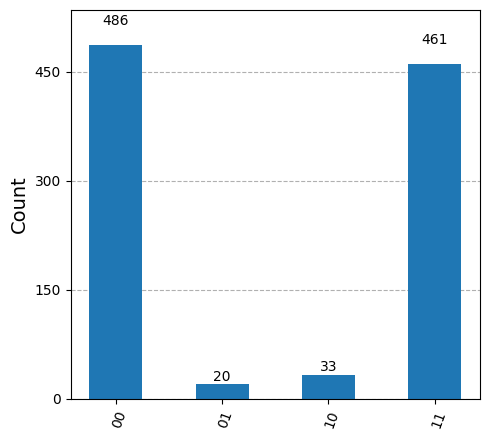

In [8]:
service = QiskitRuntimeService()
run_circuit(qc, service.backend("ibm_fez"))

### Ejecución en un simulador cuántico configurado para emular al real

`FakeFez()` es un simulador local que incorpora un modelo de ruido derivado de los datos reales de `ibm_fez`. Permite estimar el rendimiento del algoritmo en hardware real.

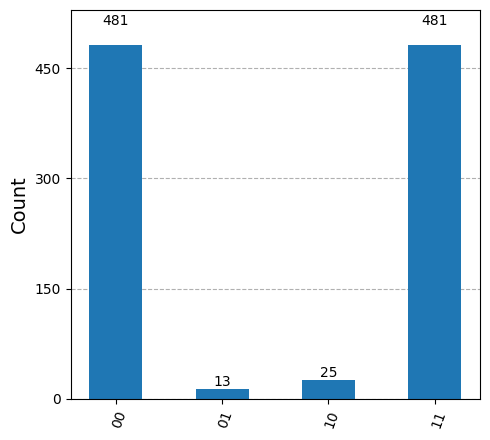

In [9]:
run_circuit(qc, FakeFez())

## Comparar las salidas y comentar los resultados

Como podemos observar, al ejecutar el circuito en un simulador cuántico ideal, se obtiene $|00 \rangle$ el 50% de las veces y $|11 \rangle$ el otro 50% de las veces.

Sin embargo, al ejecutar el circuito en el ordenador cuántico real o en el simulador que simula dicho ordenador cuántico real, medimos también los estados $|01 \rangle$ y $|10 \rangle$ en torno al 0.3-0.5% de las veces. Esto es debido a que los ordenadores cuánticos reales no son perfectos, por lo que tienen cierta tasa de error. Este error da pie a que se produzcan mediciones incorrectas, como en este caso esas 2 que hemos mencionado.

Observamos también que el ordenador real y el simulador de dicho ordenador real producen resultados muy similares, lo cual es de esperar pues el objetivo de ese simulador es comportarse tal y como ese ordenador cuántico real.

## Mostrar información

Dado que el simulador ideal no es un ordenador cuántico como tal y el fake trata de ser idéntico al ordenador cuántico real, realizamos este apartado únicamente para el ordenador cuántico real.

### Mostrar el circuito realmente implementado

Como los ordenadores cuánticos reales no implementan todas las puertas, los circuitos que definimos deben de ser transformados en circuitos equivalentes que utilicen las puertas que implementa el ordenador cuántico real que queremos utilizar. Este proceso de transformar el circuito se conoce como **transpilación**.

En nuestro caso, el circuito que hemos definido anteriormente, una vez transpilado para el ordenador cuántico `ibm_fez`, queda de la siguiente forma:

qiskit_runtime_service.__init__:WARNING:2025-11-25 20:54:33,929: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-25 20:54:33,934: Using instance: open-instance, plan: open


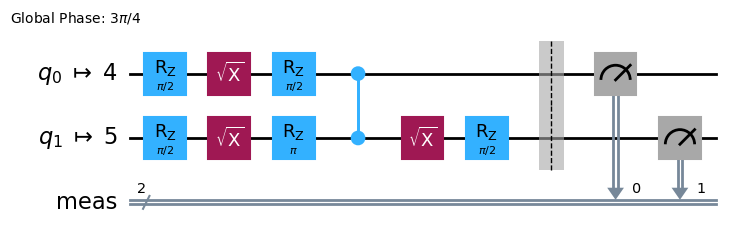

In [10]:
service = QiskitRuntimeService()
backend = service.backend("ibm_fez")
transpiled_circuit = transpile(qc, backend)
transpiled_circuit.draw(output="mpl")

### Mostrar las principales tasas de error de los qubits elegidos

Identificamos los qubits utilizados en el circuito transpilado:

In [11]:
qubits_used = set(
    transpiled_circuit.find_bit(qubit).index
    for instruction in transpiled_circuit.data
    for qubit in instruction.qubits
)

print("Qubits utilizados: " + str(qubits_used))

Qubits utilizados: {4, 5}


Con los qubits ya obtenidos, mostramos las tasas de error correspondientes a cada qubit:

In [15]:
properties = backend.properties()

for qubit in qubits_used:
    print(f"Qubit {qubit}:")

    readout_error = properties.readout_error(qubit)
    print(f" - Error de lectura: {readout_error}")

    t1 = properties.t1(qubit)
    t2 = properties.t2(qubit)
    print(f" - Tiempo T1: {t1} ")
    print(f" - Tiempo T2: {t2}")

Qubit 4:
 - Error de lectura: 0.003173828125
 - Tiempo T1: 0.00019711698303369213 
 - Tiempo T2: 0.00014597814255084223
Qubit 5:
 - Error de lectura: 0.005859375
 - Tiempo T1: 0.00019145223048835255 
 - Tiempo T2: 0.00016569128433159813


Como podemos observar, el error de lectura es del 0.3% para el qubit 4 y del 0.5% para el qubit 5. Este porcentaje explica directamente la aparición de los estados $|01 \rangle$ y $|10 \rangle$ que vimos antes. Aunque el estado final fuese correcto (que podría no serlo, puesto que las puertas también tienen errores), el dispositivo tiene una probabilidad no nula de equivocarse al medirlo.

En cuanto a los tiempos de coherencia:
- **T1 (relajación):** indica cuánto tiempo el qubit puede permanecer en el estado $|0 \rangle $ antes de caer al estado $|0 \rangle$ ($\sim 190\mu s$).
- **T2 (desfase):** indica cuánto tiempo se mantiene la fase cuántica ($\sim 145\mu s$ y $\sim 166\mu s$).

Dado que el circuito del estado de Bell que hemos implementado tiene una profundidad muy baja, estos tiempos de coherencia son más que suficientes para ejecutar el circuito sin que supongan un problema (las puertas operan en nanosegundos y los tiempos de coherencia son microsegundos).

### Mostrar el mapa de errores

qiskit_runtime_service.backends:WARNING:2025-11-25 20:54:35,315: Using instance: open-instance, plan: open


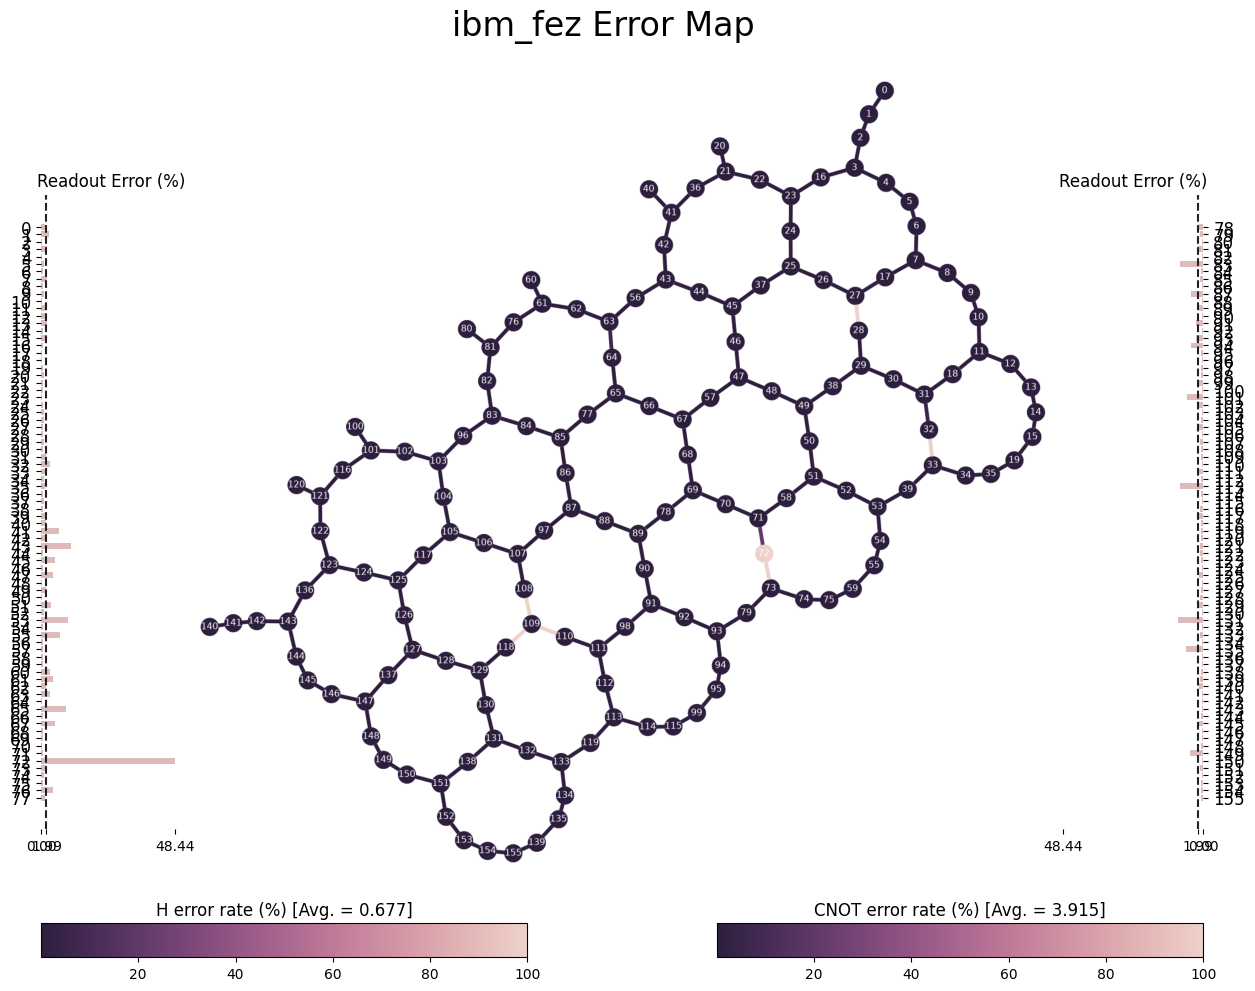

In [13]:
plot_error_map(service.backend("ibm_fez"))

En primer lugar, observamos que los qubits físicos 4 y 5 tienen conexión directa en la topología del chip. Esto valida la asignación realizada por el transpilador, puesto que de no tener dicha conexión directa, se deberían de introducir puertas SWAP, lo que aumentaría la profundidad del circuito, ya que cada SWAP se implementa con 3 CNOTs.

El mapa confirma también que los qubits que estamos utilizando no se encuentran en una zona con componentes defectuosos.

Por último, los gráficos de barras laterales nos permiten comparar el error de lectura de los diferentes qubits. Vemos que los qubits 4 y 5 presentan tasas de error de lectura bajas con respecto al resto de qubits.